In [7]:
import os
import json
from pathlib import Path

import torch

import matplotlib
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
from dotenv import load_dotenv
from scipy.ndimage import rotate
from yolov5.models.common import Detections

from utils.yolo import get_teeth_ROI
from utils.shortcut import quick_get_roi, get_fake_result

load_dotenv()
matplotlib.use('module://matplotlib_inline.backend_inline')

%matplotlib inline



In [8]:
model_path = Path(os.getenv('YOLO_MODEL_DIR')) / '8-bound.pt'
model = torch.hub.load(r'..\YOLO', 'custom', path=model_path, source='local') if model_path.is_file() else None
data_dir = Path(os.getenv('DATASET_DIR')) / 'phase-2'
data_dir


PosixPath('/Users/lucyxu/PycharmProjects/datasets/phase-2')

In [9]:
image_paths = list(data_dir.glob('00008026.jpg'))
image_path = image_paths[0]
image_name = image_path

image_path.name


'00008026.jpg'

/opt/miniconda3/envs/pt113/lib/python3.9/site-packages/yolov5/utils/plots.py:475: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xyxy = torch.tensor(xyxy).view(-1, 4)


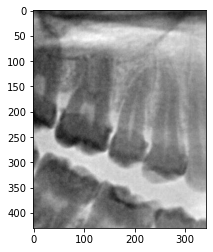

In [12]:
source, flag, tooth_position, teeth_roi_split_teeth = quick_get_roi(image_path, roi_index=0)
teeth_roi_split_teeth = teeth_roi_split_teeth[image_path.stem]

# margin = 50
plt.gray()
plt.imshow(1 - im_g)

plt.show()


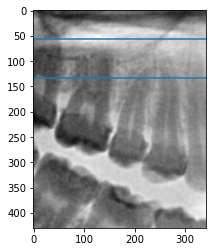

In [18]:
from scipy import ndimage
from utils.edge import get_rotation_angle, gum_jaw_separation

theta = get_rotation_angle(source, flag=flag, tooth_position=tooth_position)
source_rotated = ndimage.rotate(source, theta, reshape=True, cval=255)

gum_sep_line, jaw_sep_line, hor_valleys, hor = gum_jaw_separation(source_rotated, flag=flag)

height, width = source.shape
phi = np.radians(abs(theta))
opposite = np.sin(phi) * width
adjacent = np.cos(phi) * height

if flag == 'upper':
    source_roi = source_rotated[gum_sep_line:jaw_sep_line, :]
    y1 = gum_sep_line
    y2 = jaw_sep_line
elif flag == 'lower':
    source_roi = source_rotated[jaw_sep_line:gum_sep_line, :]
    y1 = jaw_sep_line
    y2 = gum_sep_line
else:
    raise ValueError(f'flag only accept upper or lower but get {flag}.')

t = np.tan(phi)
left_padding, right_padding = 0, 1
if theta > 0:
    left_padding = round((y2 - opposite) * t)
    right_padding = round((adjacent - y1) * t)
elif theta < 0:
    left_padding = round((adjacent - y1) * t)
    right_padding = round((y2 - opposite) * t)
source_roi = source_roi[:, left_padding:-right_padding]

plt.imshow(1 - source)
plt.axhline(gum_sep_line)
plt.axhline(jaw_sep_line)
plt.show()


In [ ]:
roi_index = 3
tooth_position_dict = {
    0: 'left',
    1: 'middle',
    2: 'right'

}
filename = image_name.stem

if model:
    results = model(image_name)
else:
    results = get_fake_result(image_name)

teeth_roi = get_teeth_ROI(results)
teeth_roi_images = teeth_roi['images'][filename]
teeth_roi_split_teeth = teeth_roi['split_teeth']

target_roi = teeth_roi_images[roi_index]
target_roi_image = target_roi['image']
flag = target_roi['flag']
tooth_position = tooth_position_dict[target_roi['number']]
im_g = cv.cvtColor(target_roi_image, cv.COLOR_RGBA2GRAY)
im_g_shape = np.array(np.array(im_g.shape)[[1, 0]])


In [ ]:

plt.gray()
plt.imshow(1 - im_g)
plt.show()
